In [1]:
import sys
sys.path.append(".")

In [2]:
import os

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdyn.models import NeuralODE

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from hmmlearn import hmm

# Toyota-MIT-Stanford Dataset (Charge)

It contains data of LFP $LiFePO_4$ batteries cycled under fast-charging.

- Nominal Capacity : 1.1 Ah
    
- Nominal Voltage 3.3 V
    

The batteries are charged through 4 stages of fast charging to 80% SOC in constant current (CC) mode and then fully charged in CC-CV model.

- Stage 1 : 0-20%
    
- Stage 2: 20-40%
    
- Stage 3: 40-60%
    
- Stage 4: 80-100%
    

In the fourth stage, the charging rate is determined by ensuring that the total charge time of the four stages is 10 min. Then all batteries were discharged at 4 C in a CC mode.

Mostly, Input types used for prediction come from charging data since discharging is a user-specific phenomenon. These datasets are divided into 2 versions as shown below:

- Complete Charging Data:
    
    - 4 Features are Time, Voltage, Current, and Temperature.
        
    - Charging data of each cycle is divided, and all charging data resampled to fixed length of 128.
        
    - So shape of each sample is (128,4)
        
- Partial Charging Data:
    
    - Practically in industries batteries are not fully charged or discharged.
        
    - charging voltage is 3.7-4.1 V for XJTU dataset, and 3.0-3.59 V for Toyota-MIT-Stanford dataset.
        
    - Similar resampling as before to obtain (128,4)

In [3]:
## Load the mat file
mat = loadmat("data/MIT/charge/min_batch-3.6-6-5.6-4.755.mat") #data/MIT/charge/min_batch-3.6-6-5.6-4.755.mat,  data/MIT/charge/min_batch-4.4-5.6-5.2-4.252.mat

battery_data = mat["battery"]

print("Shape of battery data:", battery_data.shape)

for i in range(battery_data.shape[1]):
    print(f"Shape of Selected Battery {i}:", battery_data[0,i][0].shape)

Shape of battery data: (1, 5)
Shape of Selected Battery 0: (1, 761)
Shape of Selected Battery 1: (1, 743)
Shape of Selected Battery 2: (1, 907)
Shape of Selected Battery 3: (1, 748)
Shape of Selected Battery 4: (1, 616)


# Visualizing Per Cycle Data

In [4]:
selected_battery = battery_data[0,0][0] # Select the battery at index 4 = [0,4][0]
cycle_data = selected_battery[0,0] #Change the cycle [0,23] and is based on the shape of selected_battery

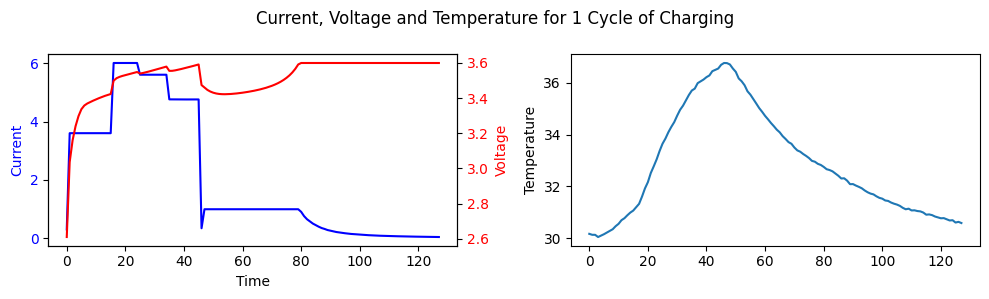

In [5]:
# Extract current, voltage, and temperature data from the cycle.
current = cycle_data["current_A"]
voltage = cycle_data["voltage_V"]
temperature = cycle_data["temperature_C"]

## Plot the data.
fig, ax = plt.subplots(1,2, figsize=(10,3))

# Plot current on the left y-axis.
ax[0].plot(current.reshape(-1,1), 'b-', label='Current')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Current', color='b')
ax[0].tick_params(axis='y', labelcolor='b')

# Create a second y-axis for voltage.
ax2 = ax[0].twinx()
ax2.plot(voltage.reshape(-1,1), 'r-', label='Voltage')
ax2.set_ylabel('Voltage', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax[1].plot(temperature.reshape(-1,1), label="Temperature")
ax[1].set_ylabel("Temperature")

plt.suptitle(f"Current, Voltage and Temperature for 1 Cycle of Charging")
fig.tight_layout()  # Adjust layout to fit both labels
plt.show()

Shape of capacity data: (761, 1)


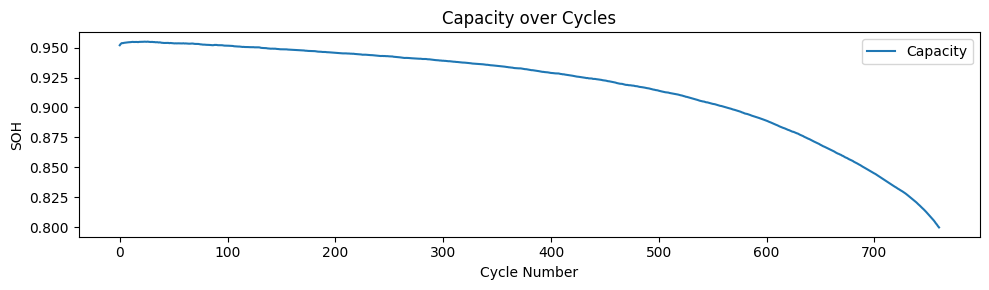

In [6]:
capacity = []

# Extract capacity data from the cycle.
for i in range(selected_battery.shape[1]):
    cycle_data = selected_battery[0,i]
    capacity.append(cycle_data["capacity"].reshape(-1,1))
capacity = np.concatenate(capacity, axis=0)

# Convert capacity to a numpy array and calculate SOH (State of Health)
soh = capacity/1.1


print("Shape of capacity data:", capacity.shape)
# Plot capacity data
plt.figure(figsize=(10, 3))
plt.plot(soh, label="Capacity")
plt.xlabel("Cycle Number")
plt.ylabel("SOH")
plt.title("Capacity over Cycles")
plt.legend()
plt.tight_layout()
plt.show()

# Build the data

In [7]:
voltage = []
current = []
temperature = []


for i in range(battery_data.shape[1]):
    selected_battery = battery_data[0,i][0]
    for j in range(selected_battery.shape[1]):
        cycle_data = selected_battery[0,j]
        current.append(cycle_data["current_A"].reshape(1,-1))
        voltage.append(cycle_data["voltage_V"].reshape(1,-1))
        temperature.append(cycle_data["temperature_C"].reshape(1,-1))

# This represents all the data from all batteries and cycles.
print("Total batch size:", len(current), len(voltage), len(temperature))

# Convert lists to numpy arrays
current = np.concatenate(current, axis=0)  # Shape: (time_steps, num_cycles)
voltage = np.concatenate(voltage, axis=0)
temperature = np.concatenate(temperature, axis=0)

print("Shape of current data:", current.shape)
print("Shape of voltage data:", voltage.shape)
print("Shape of temperature data:", temperature.shape)

Total batch size: 3775 3775 3775
Shape of current data: (3775, 128)
Shape of voltage data: (3775, 128)
Shape of temperature data: (3775, 128)


(3775, 128)


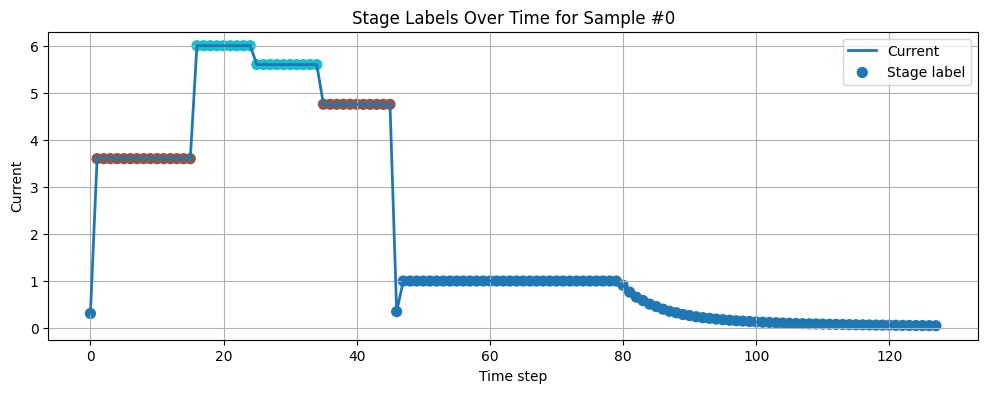

In [8]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(current.reshape(-1,1))

labels = labels.reshape(current.shape)
print(labels.shape)

# Pick a sample index (e.g., 0)
sample_idx = 0

# Extract current and stage labels for one sequence
current_sample = current[sample_idx]       # shape: (128,)
label_sample = labels[sample_idx]          # shape: (128,)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(current_sample, label="Current", linewidth=2)
plt.scatter(range(128), current_sample, c=label_sample, cmap='tab10', s=50, label="Stage label")

plt.title(f"Stage Labels Over Time for Sample #{sample_idx}")
plt.xlabel("Time step")
plt.ylabel("Current")
plt.legend()
plt.grid(True)
plt.show()


## Before Scaling

Shape of training data: (3020, 128) (3020, 128) (3020, 128)
Shape of testing data: (755, 128) (755, 128) (755, 128)


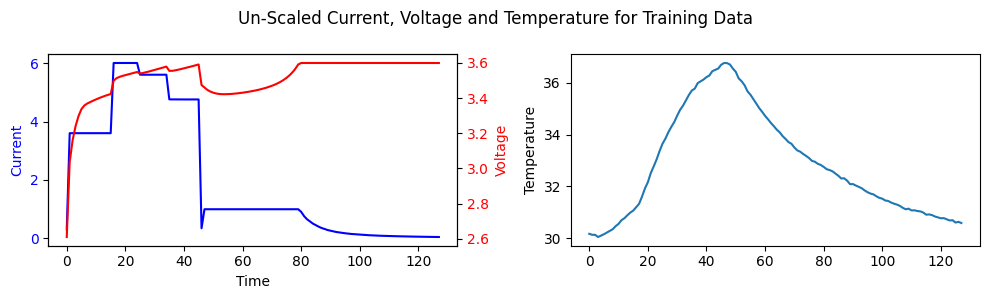

In [9]:
ratio = 0.8

# Split the data into training and testing sets
train_size = int(len(current) * ratio)
current_train = current[:train_size]
voltage_train = voltage[:train_size]
temperature_train = temperature[:train_size]
current_test = current[train_size:]
voltage_test = voltage[train_size:]
temperature_test = temperature[train_size:]

print("Shape of training data:", current_train.shape, voltage_train.shape, temperature_train.shape)
print("Shape of testing data:", current_test.shape, voltage_test.shape, temperature_test.shape)

# Plot the scaled current, voltage, and temperature data
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# Plot current on the left y-axis.
ax[0].plot(current_train[0].flatten(), 'b-', label='Current')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Current', color='b')
ax[0].tick_params(axis='y', labelcolor='b')
# Create a second y-axis for voltage.
ax2 = ax[0].twinx()
ax2.plot(voltage_train[0].reshape(-1, 1), 'r-', label='Voltage')
ax2.set_ylabel('Voltage', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax[1].plot(temperature_train[0].reshape(-1, 1), label="Temperature")
ax[1].set_ylabel("Temperature")
plt.suptitle("Un-Scaled Current, Voltage and Temperature for Training Data")
fig.tight_layout()  # Adjust layout to fit both labels
plt.show()

## After Scaling

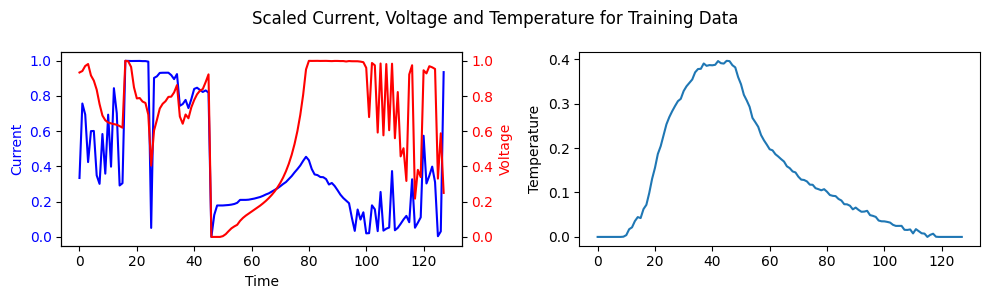

In [10]:
# Scale the data using MinMaxScaler
sc = MinMaxScaler()

# Scale the data
current_train = sc.fit_transform(current_train)
voltage_train = sc.fit_transform(voltage_train)
temperature_train = sc.fit_transform(temperature_train)
current_test = sc.transform(current_test)
voltage_test = sc.transform(voltage_test)
temperature_test = sc.transform(temperature_test)

# Plot the scaled current, voltage, and temperature data
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# Plot current on the left y-axis.
ax[0].plot(current_train[0].flatten(), 'b-', label='Current')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Current', color='b')
ax[0].tick_params(axis='y', labelcolor='b')
# Create a second y-axis for voltage.
ax2 = ax[0].twinx()
ax2.plot(voltage_train[0].reshape(-1, 1), 'r-', label='Voltage')
ax2.set_ylabel('Voltage', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax[1].plot(temperature_train[0].reshape(-1, 1), label="Temperature")
ax[1].set_ylabel("Temperature")
plt.suptitle("Scaled Current, Voltage and Temperature for Training Data")
fig.tight_layout()  # Adjust layout to fit both labels
plt.show()


In [11]:

# Convert to PyTorch tensors and create Train data
current_train = torch.unsqueeze(torch.tensor(current_train, dtype=torch.float32), dim=-1)
voltage_train = torch.unsqueeze(torch.tensor(voltage_train, dtype=torch.float32), dim=-1)
temperature_train = torch.unsqueeze(torch.tensor(temperature_train, dtype=torch.float32), dim=-1)

Y_train = torch.cat((voltage_train, temperature_train), dim=-1)  # Combine voltage and temperature
X_train = current_train  # Add channel dimension
print("Shape of X and Y Train:", X_train.shape, Y_train.shape)

# Convert to PyTorch tensors and create Test data
current_test = torch.unsqueeze(torch.tensor(current_test, dtype=torch.float32), dim=-1)
voltage_test = torch.unsqueeze(torch.tensor(voltage_test, dtype=torch.float32), dim=-1)
temperature_test = torch.unsqueeze(torch.tensor(temperature_test, dtype=torch.float32), dim=-1)
Y_test = torch.cat((voltage_test, temperature_test), dim=-1)  # Combine voltage and temperature
X_test = current_test  # Add channel dimension
print("Shape of X and Y Test:", X_test.shape, Y_test.shape)

# Create TensorDataset and DataLoader for training and testing
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Shape of X and Y Train: torch.Size([3020, 128, 1]) torch.Size([3020, 128, 2])
Shape of X and Y Test: torch.Size([755, 128, 1]) torch.Size([755, 128, 2])


# Build Model

## GRU Model

In [13]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=2, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        out, _ = self.gru(x)  # out shape: (batch_size, seq_len, hidden_size)
        out = self.fc(out)    # shape: (batch_size, seq_len, output_size)
        return out

In [14]:
model = GRUModel(input_size=1, output_size=2, hidden_size=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
num_epochs = 50

best_loss = float('inf')
checkpoint_path = 'checkpoints/checkpoint.pth' 

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X, Y in train_loader:
        output = model(X)
        loss = criterion(output, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)

    # Save best model if loss improves
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [5/50], Loss: 1.4987
Epoch [10/50], Loss: 1.2325
Epoch [15/50], Loss: 1.1306
Epoch [20/50], Loss: 0.9390
Epoch [25/50], Loss: 0.9294
Epoch [30/50], Loss: 0.9741
Epoch [35/50], Loss: 0.8902
Epoch [40/50], Loss: 0.8706
Epoch [45/50], Loss: 0.8679
Epoch [50/50], Loss: 3.9252


# Test

In [15]:
#Load the best model
# Load the checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()  # Set to evaluation mode

GRUModel(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [16]:
with torch.no_grad():
    for X, Y in test_loader:
        prediction = model(X)
        true = Y
        break  # Only first sample

print(prediction.shape, true.shape)

torch.Size([64, 128, 2]) torch.Size([64, 128, 2])


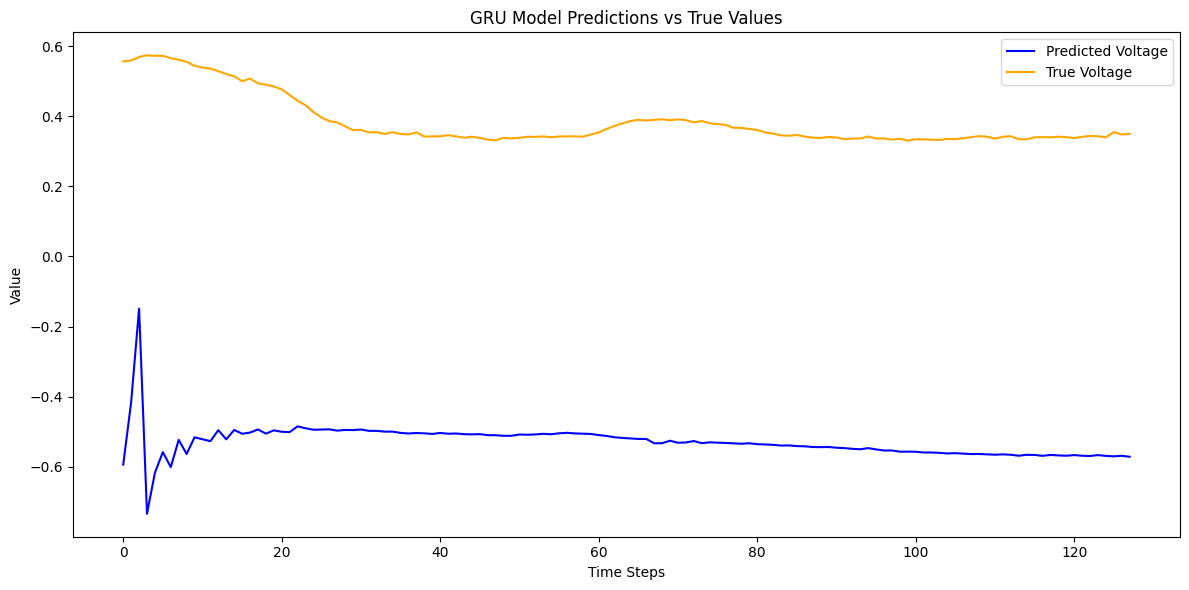

In [17]:
preds = prediction.numpy()
trues = true.numpy()

# Plot the predictions and true values
plt.figure(figsize=(12, 6))
plt.plot(preds[0, :, 1].flatten(), label='Predicted Voltage', color='blue')
plt.plot(trues[0, :, 1].flatten(), label='True Voltage', color='orange')
#plt.plot(prediction[:, :, 1].flatten(), label='Predicted Temperature', color='green')
#plt.plot(true[:, :, 1].flatten(), label='True Temperature', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('GRU Model Predictions vs True Values')
plt.legend()
plt.tight_layout()
plt.show()